# PCA e Índices bursátiles

Mariana Carmona

Hay una relación indirecta cuando usamos PCA para entender la estructura subyacente de los rendimientos de las acciones que componen un índice. Vamos a desglosar esto.

1. **Propósito de un Índice Bursátil**: Un índice como el DJIA o el S&P 500 refleja el comportamiento general de un conjunto específico de acciones, ofreciendo una visión general del mercado o del sector que representan. Estos índices se calculan y ponderan de diferentes maneras (por precio, por capitalización de mercado, etc.), y son utilizados como puntos de referencia para inversionistas y administradores de fondos.

2. **Propósito del PCA**: El PCA es una técnica de reducción de dimensionalidad. En el contexto de las finanzas, puede ser usado para identificar factores comunes que afectan a múltiples acciones. Cuando aplicas PCA a un conjunto de rendimientos de acciones, el primer componente principal (PC1) suele capturar el movimiento común más dominante entre esas acciones. Si aplicas PCA a las acciones que componen un índice, PC1 puede interpretarse, de manera muy simplificada, como un "factor de mercado" que refleja el comportamiento general del índice.

3. **Replicación del Índice usando PCA**: Cuando alguien dice que está "replicando" el comportamiento de algún índice usando PCA, lo que probablemente significa es que están construyendo un portafolio basado en los pesos dados por el primer componente principal (PC1). Dado que PC1 captura el movimiento común más dominante entre las acciones, un portafolio construido de esta manera debería, en teoría, reflejar los movimientos generales del índice. Sin embargo, no es una "replicación" directa del índice; es más bien una aproximación basada en la estructura de correlación/covarianza de las acciones.

4. **Comparación**: La razón para comparar el rendimiento de un portafolio basado en PCA con un índice es para evaluar qué tan bien ese portafolio "imita" al índice en cuestión. Si el portafolio basado en PCA sigue de cerca al índice, podría sugerir que gran parte del movimiento del índice puede explicarse por factores comunes capturados por el PCA.

Aunque PCA y los índices bursátiles no son lo mismo, el PCA puede ser utilizado en un contexto financiero para entender y, hasta cierto punto, "replicar" el comportamiento de un índice al identificar y aprovechar los movimientos comunes en las acciones que lo componen.

In [145]:
import numpy as np
import pandas as pd
import pandas_datareader.data as wb
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as optimize
from datetime import datetime
import yfinance as yf
import seaborn as sns
from scipy.stats import norm

In [146]:
activos = ['^DJI', 'JNJ', 'WMT', 'KO', 'DIS', 'PG', 'PFE', 'HD', 'RTX', 'VZ',
     'MRK', 'MCD', 'WBA', 'CVX', 'BA', 'AAPL', 'MMM', 'NKE', 'UNH', 'INTC', 'XOM',
      'IBM', 'CAT', 'V', 'CSCO', 'JPM', 'GS', 'TRV', 'MSFT', 'AXP'    
          ]

In [147]:
#activos = ['^DJI', 'MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO',
#     'DIS', 'DOW', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK',
#      'MSFT', 'NKE', 'PG', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA', 'WMT'    
#          ]

In [148]:
# Definir el rango de fechas
fecha_inicio = '2016-01-01'
fecha_fin = '2019-11-01'

# Crear DataFrame vacío para almacenar los precios mensuales
data = pd.DataFrame()

# Descargar precios mensuales para cada activo
for t in activos:
    # Utilizar 'yf.download' para obtener los precios de Yahoo Finance
    dat = yf.download(t, start=fecha_inicio, end=fecha_fin)
    
    # Agregar la columna al DataFrame 'df' con el nombre del activo
    data[t] = dat['Adj Close'].resample('MS').first()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [149]:
data.head()

,^DJI,JNJ,WMT,KO,DIS,PG,PFE,HD,RTX,VZ,...,XOM,IBM,CAT,V,CSCO,JPM,GS,TRV,MSFT,AXP
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,17148.939453,81.639336,52.529282,33.113461,97.155785,62.621033,22.713400,109.188759,49.830719,31.034880,...,54.077538,91.375252,54.885044,71.774643,20.710123,51.094421,152.116165,91.905571,48.797729,59.882359
2016-02-01,16449.179688,84.799965,57.691624,33.582062,89.768623,65.383369,21.447996,105.390030,45.654255,34.765800,...,53.260715,83.901230,51.248390,70.523071,18.412479,47.271576,137.096909,89.431778,48.717583,48.674389
2016-03-01,16865.080078,87.746880,56.802753,34.120934,92.127235,65.472000,21.570278,104.715233,49.929085,35.245232,...,57.259441,91.235802,56.471310,70.909218,21.039480,47.544628,133.380280,92.039276,47.157055,50.543068
2016-04-01,17792.750000,89.359077,59.461880,36.858437,93.466927,67.325844,21.570278,112.955452,52.513515,36.991730,...,58.442963,103.559471,62.764988,73.711769,22.498049,48.082726,137.839203,98.660133,49.838680,54.369377
2016-05-01,17891.160156,92.272552,58.196198,35.402336,98.457733,65.797066,23.552101,113.960602,54.824814,35.520374,...,62.789539,98.636787,64.243576,74.538300,21.659224,51.610237,143.324524,93.206100,45.390232,58.727810


In [150]:
dji = pd.DataFrame(data.pop('^DJI'))

In [151]:
data.head()

,JNJ,WMT,KO,DIS,PG,PFE,HD,RTX,VZ,MRK,...,XOM,IBM,CAT,V,CSCO,JPM,GS,TRV,MSFT,AXP
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,81.639336,52.529282,33.113461,97.155785,62.621033,22.713400,109.188759,49.830719,31.034880,39.470222,...,54.077538,91.375252,54.885044,71.774643,20.710123,51.094421,152.116165,91.905571,48.797729,59.882359
2016-02-01,84.799965,57.691624,33.582062,89.768623,65.383369,21.447996,105.390030,45.654255,34.765800,38.169086,...,53.260715,83.901230,51.248390,70.523071,18.412479,47.271576,137.096909,89.431778,48.717583,48.674389
2016-03-01,87.746880,56.802753,34.120934,92.127235,65.472000,21.570278,104.715233,49.929085,35.245232,38.921192,...,57.259441,91.235802,56.471310,70.909218,21.039480,47.544628,133.380280,92.039276,47.157055,50.543068
2016-04-01,89.359077,59.461880,36.858437,93.466927,67.325844,21.570278,112.955452,52.513515,36.991730,40.741123,...,58.442963,103.559471,62.764988,73.711769,22.498049,48.082726,137.839203,98.660133,49.838680,54.369377
2016-05-01,92.272552,58.196198,35.402336,98.457733,65.797066,23.552101,113.960602,54.824814,35.520374,41.955013,...,62.789539,98.636787,64.243576,74.538300,21.659224,51.610237,143.324524,93.206100,45.390232,58.727810


Se creará un dataframe llamado `a`, el cual será el mismo que `data` pero con los datos normalizados. Esto se hará con el fin de hacer una exploración de los eigenvalores.

In [152]:
normalize = lambda x: (x-x.mean())/x.std()
a =data.apply(normalize)

In [153]:
a.head()

,JNJ,WMT,KO,DIS,PG,PFE,HD,RTX,VZ,MRK,...,XOM,IBM,CAT,V,CSCO,JPM,GS,TRV,MSFT,AXP
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,-2.241054,-1.566817,-1.185941,-0.623068,-1.171272,-1.222165,-1.213210,-1.734553,-1.725364,-1.288054,...,-1.932889,-1.709756,-1.703746,-1.171832,-1.328303,-1.540155,-1.090093,-1.468223,-1.159723,-1.153747
2016-02-01,-1.978034,-1.232389,-1.068152,-1.158012,-0.940897,-1.516830,-1.339522,-2.219221,-0.875189,-1.420085,...,-2.176275,-2.537908,-1.841464,-1.209521,-1.589481,-1.751696,-1.589268,-1.661256,-1.162651,-1.728204
2016-03-01,-1.732798,-1.289972,-0.932699,-0.987212,-0.933505,-1.488355,-1.361960,-1.723138,-0.765940,-1.343766,...,-0.984789,-1.725207,-1.643676,-1.197893,-1.290864,-1.736587,-1.712792,-1.457790,-1.219647,-1.632426
2016-04-01,-1.598635,-1.117707,-0.244588,-0.890198,-0.778897,-1.488355,-1.087964,-1.423221,-0.367961,-1.159090,...,-0.632139,-0.359693,-1.405339,-1.113499,-1.125065,-1.706811,-1.564597,-0.941158,-1.121704,-1.436311
2016-05-01,-1.356182,-1.199701,-0.610600,-0.528787,-0.906395,-1.026863,-1.054542,-1.155001,-0.703243,-1.035912,...,0.662995,-0.905147,-1.349346,-1.088610,-1.220416,-1.511612,-1.382289,-1.366742,-1.284179,-1.212923


In [154]:
from sklearn.decomposition import KernelPCA
pca = KernelPCA().fit(a)

In [155]:
print(len(pca.lambdas_))

29


/Users/marianacarmona/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `lambdas_` was deprecated in version 1.0 and will be removed in 1.2. Use `eigenvalues_` instead.
  warnings.warn(msg, category=FutureWarning)


Se aplica el método `Kernel PCA` a los datos normalizados y se imprime la longitud de los autovalores, los primeros cinco autovalores, y luego los primeros cinco autovalores normalizados para que sumen 1. 
El fin de hacer esto es solo como referencia y comparación.

Recordemos que los valores propios en `PCA` y `KernelPCA` indican la cantidad de varaianza en los datos que es capturada por cada componente principal. Los componentes principales con valores propios más grandes capturan más valianza.

In [156]:
print(pca.lambdas_[:5].round(3))

[945.587 144.282  59.754  53.59   28.724]


Al observar los valores propios se puede decidir cuántos componentes principales se necesitan retener para capturar la mayor parte de la varianza en los datos, lo cual es crucial en la reducción de la dimensionalidad.

In [157]:
recompose = lambda x: x/x.sum()
print(recompose(pca.lambdas_)[:5])

[0.72458793 0.11056095 0.0457883  0.04106521 0.02201063]


se crea un objeto `KernelPCA`, especificando que queremos extraer un solo componente principal `(n_components = 1)`. Luego, ajustamos este objeto a los datos normalizados. La normalización de los datos se realiza mediante la función `normalize`, que estandariza los datos restando la media y dividiendo por la desviación estándar.

Después, utilizamos el objeto `PCA` ajustado para transformar los datos originales. El resultado de esta transformación (las proyecciones de los datos en el primer componente principal) se almacena en una nueva columna `PCA_1` en el DataFrame `dji`

In [158]:
pca = KernelPCA(n_components = 1).fit(data.apply(normalize))
dji['PCA_1'] = pca.transform(data)

<function matplotlib.pyplot.show(close=None, block=None)>

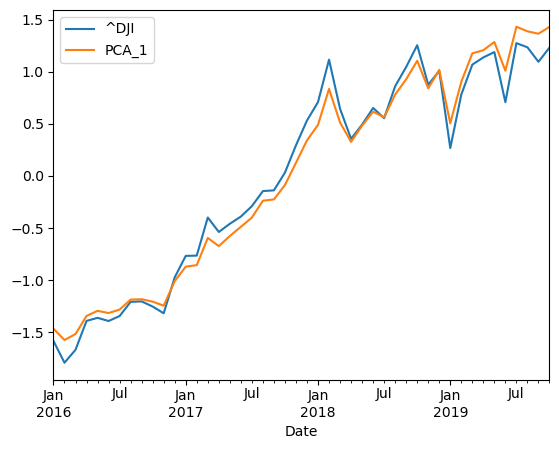

In [159]:
dji.apply(normalize).plot()
plt.show